Imports

In [3]:
import numpy as np
import random
from pysat.solvers import Solver
from collections import deque
from scipy.ndimage import label
from scipy.spatial import distance
import matplotlib.pyplot as plt
import itertools





Task 1: Generate puzzles

1.1 define puzzle representations

using a 2D array , matrix grid where it is NxN grid size. 

(A-Z) is for the region labels
( * ) is for when a star is present in the grid


In [4]:
#example with 5x5 grid 1 star per row/column/region
puzzle = [
 ['A', 'B', 'C', 'C', 'C'],
 ['A', 'B', 'C', 'C', 'D'],
 ['A', 'A', 'C', 'D', 'D'],
 ['E', 'C', 'C', 'D', 'D'],
 ['E', 'E', 'E', 'D', 'D']
 ]

solution = [
 ['0', '1', '0', '0', '0'],
 ['0', '0', '0', '1', '0'],
 ['1', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '1'],
 ['0', '0', '1', '0', '0']
]
# example from puzzle-star-battle.com solved by myself

Visualiser

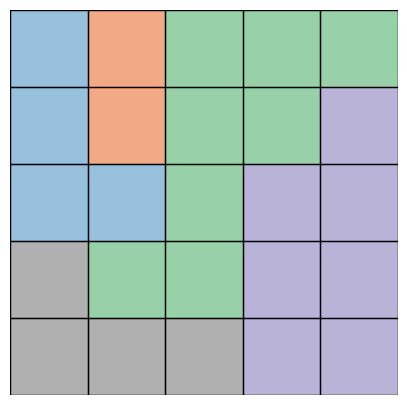

In [99]:
#visualiser
import matplotlib.pyplot as plt
import numpy as np

def visualize_star_battle(puzzle, solution):
    size = len(puzzle)
    
    # Convert NumPy array to list if necessary
    if isinstance(solution, np.ndarray):
        solution = solution.tolist()

    fig, ax = plt.subplots(figsize=(5, 5))

    # Create a grid
    for x in range(size + 1):
        ax.plot([x, x], [0, size], 'k', lw=1)  # Vertical lines
        ax.plot([0, size], [x, x], 'k', lw=1)  # Horizontal lines

    # Fill in regions with colors
    region_colors = {}
    color_map = plt.cm.tab20c
    unique_regions = sorted(set(cell for row in puzzle for cell in row))
    
    for idx, region in enumerate(unique_regions):
        region_colors[region] = color_map(idx / len(unique_regions))

    for i in range(size):
        for j in range(size):
            region = puzzle[i][j]
            ax.add_patch(plt.Rectangle((j, size - i - 1), 1, 1, color=region_colors[region], alpha=0.5))
            
            # Check integer 1 instead of string '1'
            if solution[i][j] == 1:
                ax.text(j + 0.5, size - i - 0.5, '★', fontsize=16, ha='center', va='center', color='black')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_frame_on(False)

    plt.show()

visualize_star_battle(puzzle, solution)


Similar for 10x10 grid with 2 stars per row/column/region, and even 14x14 grids with 3 stars per row/column/region

In [6]:
print("example with labels")

example with labels


1.2 Constraint representations

each row contains only k stars 
each column contains only k stars 
each region contains only k stars
no two stars can be adjacent

pre compute constraint maps

find values about puzzle

In [7]:
def get_star_limit(grid_size):
    if grid_size == 5:
        return 1
    elif grid_size == 6:
        return 1
    elif grid_size == 8:
        return 1
    elif grid_size == 10:
        return 2
    elif grid_size == 14:
        return 3
    else:
        raise ValueError(f"Grid size {grid_size} not supported")

Validate puzzles

In [8]:
def validate_solution(puzzle,solution):
    #get number of stars for grid size of puzzle
    grid_size =len(puzzle)
    star_lim = get_star_limit(grid_size)

    unique_regions = set(cell for row in puzzle for cell in row)

    # number of regions matches the grid size
    if len(unique_regions) != grid_size:
        print("num regions doesnt match grid size")
        return False

    #track star counts in row, column, region
    row_counts = np.zeros(len(puzzle), dtype = int)
    col_counts = np.zeros(len(puzzle[0]),dtype=int)
    region_counts = {region: 0 for region in set([item for sublist in puzzle for item in sublist])}

    # check puzzle and solution dimentions match
    if len(puzzle) != len(solution) or len(puzzle[0]) != len(solution):
        print("puzle dimensions dont match")
        return False
    
    for r in range(grid_size):
        for c in range(grid_size):
            if solution[r][c] == '1':
                row_counts[r]+=1
                col_counts[c]+=1
                region = puzzle[r][c]

                #count stars in region
                if region not in region_counts:
                    region_counts[region]=0
                region_counts[region]+=1
    
    # check each row,column,region has exactly n stars 
    if not (all(count == star_lim for count in row_counts) and
            all(count == star_lim for count in col_counts) and
            all(count == star_lim for count in region_counts.values())):
        print("row col or region wrong no stars")
        return False
    
    #ensure stars dont touch diagnoally
    for r in range(grid_size):
        for c in range(grid_size):
            if solution[r][c] == '1':
                # check adjacent cells for stars
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        if dr == 0 and dc == 0:
                            continue
                        nr, nc = r + dr, c + dc
                        if 0 <= nr < len(puzzle) and 0 <= nc < len(puzzle[0]):
                            if solution[nr][nc] == '1':
                                print("stars touch horizontal")
                                return False
                            
    return True

In [9]:
#checking this works
valid = validate_solution(puzzle,solution)
print("solution?", valid)

solution? True


Some example puzzles to test 

In [10]:
#example puzzles 
puzzle_5x5 = [
    ['A', 'B', 'C', 'D', 'E'],
    ['A', 'B', 'C', 'D', 'F'],
    ['A', 'B', 'C', 'G', 'F'],
    ['A', 'H', 'C', 'G', 'F'],
    ['I', 'H', 'C', 'G', 'F']
]

solution_5x5 = [
    ['0', '0', '0', '1', '0'],
    ['0', '0', '1', '0', '0'],
    ['0', '0', '0', '0', '1'],
    ['1', '0', '0', '0', '0'],
    ['0', '1', '0', '0', '0']
]

puzzle_10x10 = [
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
]

solution_10x10 = [
    ['0', '1', '0', '0', '1', '0', '0', '0', '0', '0'],
    ['1', '0', '0', '0', '0', '1', '0', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '1', '0', '0', '0'],
    ['0', '1', '0', '0', '0', '0', '0', '1', '0', '0'],
    ['1', '0', '0', '1', '0', '0', '0', '0', '0', '0'],
    ['0', '0', '0', '0', '1', '0', '1', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '0', '1', '0', '0'],
    ['1', '0', '0', '1', '0', '0', '0', '0', '0', '0'],
    ['0', '1', '0', '0', '0', '1', '0', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '0', '0', '1', '0']
]

puzzle_14x14 = [
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
    ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N'],
]

solution_14x14 = [
    ['0', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0'],
    ['0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0'],
    ['1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0'],
    ['0', '0', '0', '0', '0', '1', '0', '1', '0', '1', '0', '0', '0', '0'],
    ['1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0'],
    ['0', '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '0', '0'],
    ['0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0'],
    ['1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '1', '0'],
    ['0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0'],
    ['1', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0'],
    ['0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0'],
    ['0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0'],
    ['1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0']
]


In [11]:
print(validate_solution(puzzle_5x5,solution_5x5),
      validate_solution(puzzle_10x10, solution_10x10),
      validate_solution(puzzle_14x14, solution_14x14))

num regions doesnt match grid size
row col or region wrong no stars
row col or region wrong no stars
False False False


1.3 Basic Generation Algorithm using sat solver

In [12]:
def validate_stars(grid, star_lim):
    size = len(grid)
    
    # Check each column has exact num stars
    if not all(np.sum(grid[:, col]) == star_lim for col in range(size)):
        return False

    # Check no adjacent stars
    for r in range(size):
        for c in range(size):
            if grid[r, c] == 1:
                #directons orthogonal
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        if (dr == 0 and dc == 0) or not (0 <= r + dr < size and 0 <= c + dc < size):
                            continue
                        if grid[r + dr, c + dc] == 1:
                            return False
    return True

In [13]:
def adjacent_star(grid, r, c):
    size = len(grid)
    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            nr, nc = r + dr, c + dc
            if 0 <= nr < size and 0 <= nc < size and grid[nr, nc] == 1:
                return True
    return False

In [14]:
#start
def generate_star_solution(size):
    star_lim = get_star_limit(size)
    grid = np.zeros((size, size), dtype=int)

    # available positions per column to check exact star limits
    column_counts = [0] * size
    
    for row in range(size):
        valid_positions = list(range(size))
        random.shuffle(valid_positions)  
        stars_placed = 0

        for col in valid_positions:
            # check column limit and adjacency
            if column_counts[col] < star_lim and not adjacent_star(grid, row, col):
                grid[row, col] = 1
                column_counts[col] += 1
                stars_placed += 1
                if stars_placed == star_lim:
                    break

    # validate
    if not validate_stars(grid, star_lim):
        return generate_star_solution(size)  # Retry in rare failure cases

    return grid

In [15]:
# check first secton
solution1 = generate_star_solution(5)

print(solution1)


[[0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]


regions

In [16]:
def generate_regions(solution):
    grid_size = solution.shape[0]

    # get star positions
    stars = [(r, c) for r in range(grid_size) for c in range(grid_size) if solution[r, c] == 1]

    # initialize region map with -1 (unassigned cells)
    region_map = -np.ones((grid_size, grid_size), dtype=int)

    # directions in order left, right, up, down
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # assign each star a unique region number and initialize expansion queue
    expansion_queue = []
    for region_id, (r, c) in enumerate(stars):
        region_map[r, c] = region_id
        expansion_queue.append((r, c, region_id))  # (row, col, region_id)

    # list to store expanded cells to revisit when no further expansion is possible
    expansion_history = expansion_queue.copy()

    while expansion_queue:
        new_queue = []
        
        for r, c, region_id in expansion_queue:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc  # Compute new row/col

                if 0 <= nr < grid_size and 0 <= nc < grid_size and region_map[nr, nc] == -1:
                    # assign the region and add to new expansion queue
                    region_map[nr, nc] = region_id
                    new_queue.append((nr, nc, region_id))
                    expansion_history.append((nr, nc, region_id))  # store for fallback expansion

        # if no new cells were expanded, revisit earlier expanded cells
        if not new_queue and expansion_history:
            new_queue = expansion_history.copy()
            expansion_history.clear()

        expansion_queue = new_queue

    # Convert numeric regions to lettered regions
    unique_regions = np.unique(region_map)
    region_map_dict = {val: chr(65 + i) for i, val in enumerate(unique_regions)}
    lettered_regions = np.array([[region_map_dict[val] for val in row] for row in region_map])

    return lettered_regions

In [17]:
print(solution1)
solution1 = np.array(solution1,dtype=int)
print(solution1)

[[0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]
[[0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]


In [18]:
puzzle1 = generate_regions(solution1)
print(puzzle1)
print(solution1)

[['A' 'A' 'A' 'B' 'B']
 ['C' 'A' 'B' 'B' 'B']
 ['C' 'C' 'D' 'B' 'B']
 ['C' 'D' 'D' 'D' 'E']
 ['C' 'D' 'D' 'E' 'E']]
[[0 1 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]


trying new for 10x10 and 14x14

In [55]:
def group_stars(stars, stars_per_region, grid_size):
    star_set = set(stars)
    grouped_stars = set()
    star_groups = []

    def find_nearest_stars(start):
        """Finds the nearest ungrouped stars to `start`, up to `stars_per_region`."""
        queue = deque([start])
        current_group = []
        visited = set()

        while queue and len(current_group) < stars_per_region:
            r, c = queue.popleft()
            if (r, c) in grouped_stars or (r, c) in visited:
                continue

            current_group.append((r, c))
            grouped_stars.add((r, c))
            visited.add((r, c))

            # don't try to connect stars within the group
            if grid_size > 8:
                ungrouped_stars = [s for s in star_set if s not in grouped_stars]
                ungrouped_stars.sort(key=lambda s: abs(s[0] - r) + abs(s[1] - c))
                queue.extend(ungrouped_stars[:stars_per_region - len(current_group)])

        return current_group

    for start_star in stars:
        if start_star not in grouped_stars:
            star_groups.append(find_nearest_stars(start_star))

    return star_groups





def generate_regions2(solution):
    grid_size = solution.shape[0]
    
    # Determine required stars per region
    per_region = get_star_limit(grid_size)

    # Get star positions
    stars = [(r, c) for r in range(grid_size) for c in range(grid_size) if solution[r, c] == 1]

    # Ensure valid division of stars
    assert len(stars) % per_region == 0, "Star count must be divisible by stars_per_region!"

    # Group stars into regions
    star_groups = group_stars(stars, per_region, grid_size)

    # Initialize region map with -1 (unassigned)
    region_map = -np.ones((grid_size, grid_size), dtype=int)

    # Connect stars within each group (only for grids > 5×5)
    if grid_size > 5:
        for region_id, star_group in enumerate(star_groups):
            queue = deque([star_group[0]])
            visited = set(star_group)
            region_map[star_group[0]] = region_id

            while queue:
                r, c = queue.popleft()

                # Expand to the closest unvisited star within the group
                for sr, sc in star_group:
                    if (sr, sc) not in visited:
                        path = bfs_shortest_path((r, c), (sr, sc), region_map)
                        for pr, pc in path:
                            region_map[pr, pc] = region_id
                        visited.add((sr, sc))
                        queue.append((sr, sc))

    # Expand the regions outward
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    expansion_queue = [(r, c, i) for i, group in enumerate(star_groups) for r, c in group]

    while expansion_queue:
        new_queue = []
        for r, c, region_id in expansion_queue:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < grid_size and 0 <= nc < grid_size and region_map[nr, nc] == -1:
                    # Ensure the cell connects orthogonally (not diagonally)
                    if any(0 <= nr + dr < grid_size and 0 <= nc + dc < grid_size and 
                           region_map[nr + dr, nc + dc] == region_id for dr, dc in directions):
                        region_map[nr, nc] = region_id
                        new_queue.append((nr, nc, region_id))
        expansion_queue = new_queue

    # Convert numeric regions to letters
    unique_regions = np.unique(region_map)
    region_map_dict = {val: chr(65 + i) for i, val in enumerate(unique_regions)}
    lettered_regions = np.array([[region_map_dict[val] for val in row] for row in region_map])

    return lettered_regions

def bfs_shortest_path(start, end, region_map):
    """Finds the shortest path between two points using BFS (only orthogonal moves)."""
    queue = deque([(start, [])])
    visited = set()

    while queue:
        (r, c), path = queue.popleft()
        if (r, c) == end:
            return path + [(r, c)]

        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Only orthogonal moves
            nr, nc = r + dr, c + dc
            if (0 <= nr < region_map.shape[0] and 0 <= nc < region_map.shape[1] and
                    (nr, nc) not in visited and region_map[nr, nc] == -1):
                queue.append(((nr, nc), path + [(r, c)]))
                visited.add((nr, nc))

    return []  # Fallback if no path found


version 3

In [100]:
def group_stars(stars, stars_per_region):
        # Function to group stars into regions
        star_set = set(stars)  # Set for faster lookup
        grouped_stars = set()
        star_groups = []

        def find_group(start):
            """Finds the nearest ungrouped stars to `start`, up to `stars_per_region`."""
            queue = deque([start])
            current_group = []
            visited = set()  # Avoid revisiting stars

            while queue and len(current_group) < stars_per_region:
                r, c = queue.popleft()
                if (r, c) in grouped_stars or (r, c) in visited:
                    continue

                current_group.append((r, c))
                grouped_stars.add((r, c))
                visited.add((r, c))

                # Find all ungrouped stars sorted by Manhattan distance
                ungrouped_stars = [s for s in star_set if s not in grouped_stars]
                ungrouped_stars.sort(key=lambda s: abs(s[0] - r) + abs(s[1] - c))

                # Add nearest stars to the queue
                queue.extend(ungrouped_stars[:stars_per_region - len(current_group)])

            return current_group

        # Group stars until all are grouped
        for start_star in stars:
            if start_star not in grouped_stars:
                star_groups.append(find_group(start_star))

        return star_groups

In [121]:
def generate_regions3(solution):
    grid_size = solution.shape[0]
    
    # Determine required stars per region
    per_region = get_star_limit(grid_size)
    
    # Get star positions
    stars = [(r, c) for r in range(grid_size) for c in range(grid_size) if solution[r, c] == 1]

    # Ensure valid division of stars
    assert len(stars) % per_region == 0, "Star count must be divisible by stars_per_region!"

    # Initialize region map with -1 (unassigned)
    region_map = -np.ones((grid_size, grid_size), dtype=int)

    # Directions in order left, right, up, down
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # For larger grids, we need to group stars into valid regions
    grouped_stars = set()
    star_groups = []



    # Group stars into regions based on the required stars per region
    star_groups = group_stars(stars, per_region)

    # Now, assign each group to a region and expand the regions
    expansion_queue = []
    region_id = 0

    for star_group in star_groups:
    # Assign a region ID to all stars in the current group
        for r, c in star_group:
            region_map[r, c] = region_id
            expansion_queue.append(((r, c), region_id))  # ✅ Expand from all stars
        region_id += 1


    # List to store expanded cells to revisit when no further expansion is possible
    expansion_history = expansion_queue.copy()

    while expansion_queue:
        new_queue = []
        
        for (r, c), region_id in expansion_queue:
            for dr, dc in directions:
                nr, nc = r + dr, c + dc  # Compute new row/col

                if 0 <= nr < grid_size and 0 <= nc < grid_size and region_map[nr, nc] == -1:
                    # assign the region and add to new expansion queue
                    region_map[nr, nc] = region_id
                    new_queue.append(((nr, nc), region_id))
                    expansion_history.append(((nr, nc), region_id))  # store for fallback expansion

        # If no new cells were expanded, revisit earlier expanded cells
        if not new_queue and expansion_history:
            new_queue = expansion_history.copy()
            expansion_history.clear()

        expansion_queue = new_queue

    # Convert numeric regions to lettered regions
    unique_regions = np.unique(region_map)
    region_map_dict = {val: chr(65 + i) for i, val in enumerate(unique_regions)}
    lettered_regions = np.array([[region_map_dict[val] for val in row] for row in region_map])

    return lettered_regions


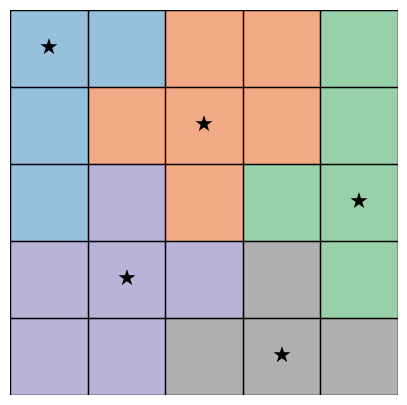

In [124]:
solution5 = generate_star_solution(5)
puzzle5 = generate_regions3(solution5)
visualize_star_battle(puzzle5, solution5)

[['D' 'B' 'B' 'A' 'A' 'A' 'A' 'A' 'C' 'C']
 ['D' 'B' 'B' 'B' 'A' 'A' 'A' 'C' 'C' 'C']
 ['D' 'D' 'B' 'B' 'E' 'C' 'C' 'C' 'C' 'C']
 ['D' 'B' 'B' 'B' 'E' 'E' 'C' 'F' 'C' 'F']
 ['D' 'D' 'B' 'B' 'E' 'E' 'F' 'F' 'F' 'F']
 ['D' 'G' 'B' 'H' 'E' 'E' 'E' 'F' 'F' 'F']
 ['G' 'G' 'G' 'H' 'H' 'E' 'E' 'F' 'I' 'F']
 ['G' 'G' 'G' 'H' 'I' 'I' 'I' 'I' 'I' 'I']
 ['G' 'G' 'G' 'H' 'H' 'I' 'I' 'J' 'I' 'J']
 ['G' 'G' 'G' 'H' 'H' 'I' 'J' 'J' 'J' 'J']]


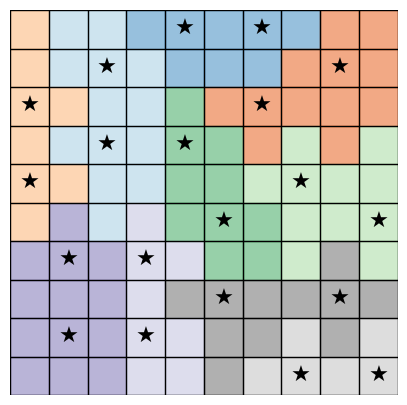

[[0 0 0 0 1 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 1]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1]]


In [122]:
solution10 = generate_star_solution(10)
puzzle10 = generate_regions3(solution10)
print(puzzle10)
visualize_star_battle(puzzle10, solution10)
print(solution10)

[['A' 'A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'C' 'C' 'C' 'C']
 ['A' 'A' 'A' 'A' 'B' 'B' 'B' 'B' 'B' 'C' 'C' 'C' 'C' 'C']
 ['A' 'A' 'A' 'D' 'D' 'B' 'B' 'B' 'B' 'B' 'C' 'C' 'C' 'C']
 ['A' 'A' 'A' 'D' 'D' 'D' 'D' 'B' 'B' 'C' 'C' 'C' 'E' 'E']
 ['F' 'F' 'D' 'D' 'D' 'D' 'G' 'G' 'G' 'G' 'C' 'E' 'E' 'E']
 ['F' 'F' 'F' 'D' 'H' 'G' 'G' 'G' 'G' 'E' 'E' 'E' 'E' 'E']
 ['F' 'F' 'F' 'F' 'H' 'H' 'G' 'G' 'G' 'I' 'E' 'E' 'E' 'E']
 ['F' 'K' 'F' 'F' 'H' 'H' 'G' 'G' 'G' 'I' 'I' 'I' 'J' 'J']
 ['K' 'K' 'K' 'H' 'H' 'H' 'H' 'G' 'G' 'I' 'I' 'I' 'I' 'J']
 ['K' 'K' 'K' 'H' 'H' 'H' 'L' 'L' 'I' 'I' 'I' 'I' 'J' 'J']
 ['K' 'K' 'K' 'H' 'H' 'H' 'L' 'L' 'I' 'I' 'J' 'J' 'J' 'J']
 ['K' 'K' 'K' 'H' 'H' 'L' 'L' 'L' 'L' 'L' 'L' 'J' 'N' 'J']
 ['K' 'M' 'M' 'M' 'M' 'M' 'L' 'L' 'N' 'L' 'N' 'N' 'N' 'N']
 ['K' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'N' 'N' 'N' 'N' 'N' 'N']]
[[1 0 0 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 1 0 1 0]
 [0 1 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 

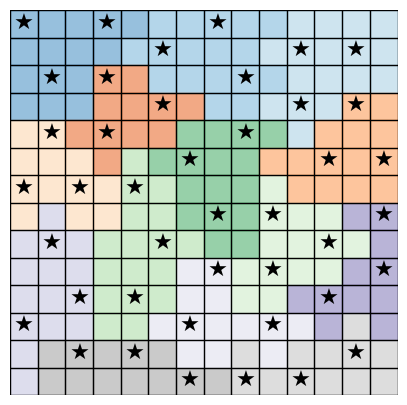

In [125]:
solution14 = generate_star_solution(14)
puzzle14 = generate_regions3(solution14)
print(puzzle14)
print(solution14)
visualize_star_battle(puzzle14, solution14)


In [97]:
print(f"the solution is {validate_solution(puzzle10, solution10)}")

row col or region wrong no stars
the solution is False


1.3 Data structure choices

In [24]:
print("examples class")

examples class


1.4 Storing and compiling puzzles

1.4 SAT solve to validate uniqueness of puzzles

1.6 Generate initial test set of puzzles

In [25]:
print("test set of puzzles")

test set of puzzles
